Library imports

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras.layers import Input
from keras.layers import Input, Lambda
from keras import backend as K

from sklearn.utils import shuffle
import pickle
import itertools as it

Mount the Google Drive folder that contains the Dataset prepareted in the DataPreparation.ipynb

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = Path("/content/gdrive/MyDrive")

dataset_dir = root_dir / "SigNature/Datasets/SigNature_integration_HQ_augmented_2"

Mounted at /content/gdrive


In [ ]:
count = 0

for folder in os.listdir(dataset_dir / "Train"):
  for img in os.listdir(dataset_dir / "Train" / folder):
    count += 1
for folder in os.listdir(dataset_dir / "Test"):
  for img in os.listdir(dataset_dir / "Test" / folder):
    count += 1

print(count)

11992


## Import dataset

In this part the dataset is imported and divided into train, validation and test. 

All images are preprocessed, importing a single channel and normalized to the range [0, 1] by dividing each pixel by 255.

In [3]:
path = dataset_dir / "Train"
content = os.listdir(path)

In [4]:
n = len(content) // 2 
n_train = int(n * 0.8) 
n_val = int(n * 0.1)

Triplets consisting of (anchor, genuine, forged) are imported.

In [ ]:
def import_triplets():
  triplets_train = []
  triplets_val = []
  triplets_test = []

  def append_triplets(list_, id):
    folder_g = path / (str(id) + "_genuine")
    folder_f = path / (str(id) + "_forged")
    folder_g_content = os.listdir(path / folder_g)
    folder_f_content = os.listdir(path / folder_f)
    anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
    random.shuffle(anchor_positive)
    for j in range(len(folder_f_content)):
      new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
      list_.append(new_triplet)

  for id in range(1, n_train):
    append_triplets(triplets_train, id)
  
  for id in range(n_train, n_train + n_val):
    append_triplets(triplets_val, id)

  for id in range(n_train + n_val, n + 1):
    append_triplets(triplets_test, id)

  return triplets_train, triplets_val, triplets_test

This piece of code is used to preprocess the images to load starting from the path. Only one channel has been preserved, and we make sure that the images are the correct size, and correct type.

In [23]:
def preprocess(img_path):
  img_obj = cv2.imread(img_path, 0) # Only 1 channel
  img_obj = np.array(img_obj).astype("float32") / 255
  img_obj = np.expand_dims(img_obj, -1)
  return img_obj

Helper function of preprocess

In [24]:
def preprocess_triplets(triplet):
    anchor = triplet[0]
    positive = triplet[1]
    negative = triplet[2]
    
    return (
        preprocess(anchor),
        preprocess(positive),
        preprocess(negative),
    )

In [ ]:
def load(triplets):
  anchor_dataset, positive_dataset, negative_dataset = [], [], []
  for triplet in triplets:
    anchor_dataset.append( triplet[0].as_posix())
    positive_dataset.append( triplet[1].as_posix())
    negative_dataset.append( triplet[2].as_posix())
  anchor_dataset, positive_dataset, negative_dataset = shuffle(anchor_dataset, positive_dataset, negative_dataset, random_state=42)
  dataset = np.array(list(zip(anchor_dataset, positive_dataset, negative_dataset)))
  dataset = [preprocess_triplets(i) for i in tqdm(dataset)]
  return dataset

This is the function to load the dataset from scratch, and to save the pickle file to the relative path

In [ ]:
def load_slow():
  triplets_train, triplets_val, triplets_test = import_triplets()
  train = load(triplets_train)
  val = load(triplets_val)
  test = load(triplets_test)

  f = open(dataset_dir / 'triplets.pickle', 'wb')
  pickle.dump([train, val, test], f)                     
  f.close()
  
  return train, val, test

This is the function to load the dataset from the pickle file

In [5]:
def load_fast():
  f = open(dataset_dir / 'triplets.pickle', 'rb')     
  train, val, test = pickle.load(f)
  f.close()
  return train, val, test

In [6]:
if os.path.exists(dataset_dir / 'triplets.pickle'):
  print("Loading fast..")
  train, val, test = load_fast()
else:
  print("Loading slow..")
  train, val, test = load_slow()

Loading fast..


# Siamese network


## Make pairs for the siamese network

This function produce the pairs of (anchor, img) to give in input to the siamese network.

In [7]:
def make_pairs(x):
  pairs = []
  labels = []

  for triplet in x:
      # triplet = (anchor, positive, negative)
      x1 = triplet[0]
      x2 = triplet[1]
      pairs += [[x1, x2]]
      labels += [1] # Matching example

      x1 = triplet[0]
      x2 = triplet[2]
      pairs += [[x1, x2]]
      labels += [0] # Non matching example
      
  return np.array(pairs), np.array(labels).astype("float32")

In [8]:
pairs_train, labels_train = make_pairs(train)
pairs_val, labels_val = make_pairs(val)
pairs_test, labels_test = make_pairs(test)

In [9]:
pairs_train.shape

(8850, 2, 128, 256, 1)

This part is util to divide the pairs in positive pairs and negative pairs

In [10]:
x_train_1 = pairs_train[:, 0] # Negative pairs
x_train_2 = pairs_train[:, 1] # Positive pairs

In [11]:
x_val_1 = pairs_val[:, 0] # Negative pairs
x_val_2 = pairs_val[:, 1] # Positive pairs

In [12]:
x_test_1 = pairs_test[:, 0] # Negative pairs
x_test_2 = pairs_test[:, 1] # Positive pairs

The memory is flushed by deleting the train, test and val. Those are not been used anymore.

In [13]:
del train
del test
del val

## Build the siamese network

Hyperparameters of the best siamese configuration found.

In [14]:
epochs = 15
batch_size = 32
margin = 1  # Margin for constrastive loss.

The distance measure of the pairs is the euclidean distance

In [15]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

Initializers define the way to set the initial random weights of layers.

This method of initializing became famous through a paper submitted in 2015 by He-et-al. In this method, the weights are initialized keeping in mind the size of the previous layer which helps in attaining a global minimum of the cost function faster and more efficiently. This provides a controlled initialization hence the faster and more efficient gradient descent.

In [16]:
seed = 42
W_init = keras.initializers.HeNormal(seed=seed)
b_init = keras.initializers.HeNormal(seed=seed)

The network is made up with the Keras functional API.<br>
This is the implementation of the model described in the relation.



In [17]:
# Shared CNN/embedding network
input = layers.Input((128, 256, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(64, (5, 5), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(1024, activation="relu", kernel_initializer=W_init, bias_initializer=b_init)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu", kernel_initializer=W_init, bias_initializer=b_init)(x)
embedding_network = keras.Model(input, x)

#Inputs layers
input_1 = layers.Input((128, 256, 1))
input_2 = layers.Input((128, 256, 1))

# Two siamese network / tower
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

#Siamese euclidean layer and sigmoid output
merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

The contrastive loss is used in combination with the euclidean distance to separate the positive embedding from the negative embeddings.<br>
A nice explanation of the neworks and contrastive loss has founded [here]( https://gombru.github.io/2019/04/03/ranking_loss/)

In [18]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

This part compiles the siamese model, using the Adam optimizer with a learning rate equals to 6 * 10^-5 and the accuracy metric to see the validation improvement during the train.

In [ ]:
siamese.compile(loss=loss(margin=margin), optimizer=optimizers.Adam(0.00006), metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          111033476   ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

The keras callback has been used to retrive the best model in term of validation accuracy during the train. The model is then save as .h5 file.

In [ ]:
from keras.callbacks import ModelCheckpoint
fBestModel = dataset_dir / 'Siamese_best.h5'
bm_callback = ModelCheckpoint(fBestModel, monitor='val_accuracy', verbose=0, saveBestOnly=True)

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks = [bm_callback]
)

Epoch 1/15
554/554 [==============================] - 163s 272ms/step - loss: 0.2110 - accuracy: 0.6666 - val_loss: 0.3213 - val_accuracy: 0.5186
Epoch 2/15
554/554 [==============================] - 153s 276ms/step - loss: 0.1617 - accuracy: 0.7924 - val_loss: 0.2534 - val_accuracy: 0.5828
Epoch 3/15
554/554 [==============================] - 153s 276ms/step - loss: 0.1319 - accuracy: 0.8686 - val_loss: 0.2244 - val_accuracy: 0.6352
Epoch 4/15
554/554 [==============================] - 151s 272ms/step - loss: 0.1125 - accuracy: 0.9159 - val_loss: 0.1883 - val_accuracy: 0.7028
Epoch 5/15
554/554 [==============================] - 151s 272ms/step - loss: 0.0982 - accuracy: 0.9416 - val_loss: 0.1810 - val_accuracy: 0.7179
Epoch 6/15
554/554 [==============================] - 151s 273ms/step - loss: 0.0865 - accuracy: 0.9602 - val_loss: 0.1660 - val_accuracy: 0.7634
Epoch 7/15
554/554 [==============================] - 151s 272ms/step - loss: 0.0787 - accuracy: 0.9659 - val_loss: 0.1775 -

Load from the disk the best model saved before, with the same parameters of margin and adam learning rate

In [19]:
siamese.load_weights(dataset_dir / "Siamese_best_77%.h5")
siamese.compile(loss=loss(margin=margin), optimizer=optimizers.Adam(0.00006), metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          111033476   ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In this part is presented graphically the train phase, for each epoch is present the calculated accuracy and contrastive loss.

The model it's very difficult to train, in order to understand how to separate two similar signatures of a never seen user, it has to do what is called the "one-shot learning". The model seems to learn how to do it, until the epoch 4/5 then the model tends to the overfitting. This is also seen in the loss picture.

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

plt_metric(history=history.history, metric="accuracy", title="Model accuracy")
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

NameError: ignored

The early test on the test set makes a good accuracy, but the threshold is not setted yet.

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

41/41 [==============================] - 9s 154ms/step - loss: 0.1535 - accuracy: 0.7653
test loss, test acc: [0.15347550809383392, 0.7652904987335205]


To adjust the threshold, all the validation predictions are retrived.

In [ ]:
predictions = siamese.predict([x_val_1, x_val_2])

NameError: ignored

Then a grid search with step size of 0.01 is performed to the validation set, in order to get the best threshold t* that maximizes the validation accuracy.

In [ ]:
from sklearn.metrics import classification_report

accuracies = []
for step in np.arange(0, 1, 0.01):
  pred = []

  for i in range(len(predictions)):
    if predictions[i][0] >= step:
      pred.append(1)
    else:
      pred.append(0)
  accuracies.append(classification_report(pred, labels_val, zero_division=0, output_dict=True)['accuracy'])

In [ ]:
threshold = np.argmax(accuracies)/100

In [ ]:
print("Accuracy max", accuracies[np.argmax(accuracies)], "with threshold", threshold) 

Accuracy max 0.8181818181818182 with threshold 0.77


A plot of the accuracy in according to the variation of the threshold is seen in figure below.

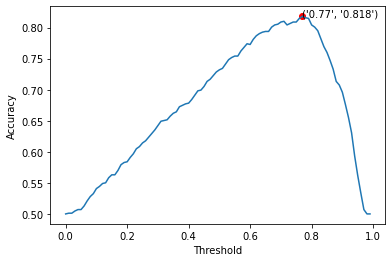

In [ ]:
x = list(np.arange(0, 1, 0.01))
y = accuracies
plt.plot(x,y)

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
p = (str(np.argmax(accuracies)/100), '%.3f'%(max(accuracies)))
plt.annotate(str(p), (np.argmax(accuracies)/100, max(accuracies)))
plt.scatter([np.argmax(accuracies)/100], [max(accuracies)], c='red')

plt.show()

## Evaluation on test set

After the calculation of the threshold, the accuracies has been calculated on the test set. The validation set contains users that the siamese model has never seen, so the expectation is that also in the train set, that cointains users never seen before, has the same accuracy.

In [20]:
path_train = dataset_dir / "Train"
path_test = dataset_dir / "Test"
content = os.listdir(path_train)

Here is implemented the election approach to test the siamese network, according to the description in the relation.

In [ ]:
def election(anchors, img):
  count = 0
  for i in anchors:
    if siamese.predict([np.array([i]), np.array([img])])[0] >= threshold:
      count += 1
  return 1 if count > len(anchors)/2 else 0

In [ ]:
def predictions_elections(n_anchors = 1):
  predictions = {}
  for id in range(n_train, n+1):
    predictions[id] = [[], []] 
    
    folder_g_train = path_train / (str(id) + "_genuine")
    folder_g_content_train = os.listdir(path_train / folder_g_train)
    r = random.sample(range(len(os.listdir(path_train / folder_g_train))), n_anchors)
    anchors = []
    for i in r:
      anchors.append(preprocess((folder_g_train / folder_g_content_train[i]).as_posix()))


    folder_g_test = path_test / (str(id) + "_genuine")
    folder_f_test = path_test / (str(id) + "_forged")
    folder_g_content_test = os.listdir(path_test / folder_g_test)
    folder_f_content_test = os.listdir(path_test / folder_f_test)

    for img in folder_g_content_test:
      predictions[id][0].append(election(anchors, preprocess((folder_g_test / img).as_posix())))
      predictions[id][1].append(1)

    for img in folder_f_content_test:
      predictions[id][0].append(election(anchors, preprocess((folder_f_test / img).as_posix())))
      predictions[id][1].append(0)
  
  return predictions

Retrive the classification report of the predictions

In [ ]:
def report(predictions):
  predictions_tot = predictions[n_train][0]
  for id in range(n_train+1, n+1):
    predictions_tot = np.concatenate((predictions_tot, predictions[id][0]))
  real_labels_tot = predictions[n_train][1]
  for id in range(n_train+1, n+1):
    real_labels_tot = np.concatenate((real_labels_tot, predictions[id][1]))
  return classification_report(predictions_tot, real_labels_tot, digits=6, output_dict=True) 

Max common lenght defines the max common signatures for each user id in the dataset, this is done to make a unified plot of the predictions.

In [ ]:
def max_common_lenght():
  lt = []
  for id in range(n_train, n+1):
    folder_g_train = path_train / (str(id) + "_genuine")
    folder_g_content_train = os.listdir(path_train / folder_g_train)
    lt.append(len(folder_g_content_train))
  return min(lt)

mcl = max_common_lenght()

Get the report for the elections with anchors in {1, 3, 5, 7, 9, 11, 13, 15}

In [ ]:
reports = []
for i in tqdm(range(1, mcl + 1, 2)):
  reports.append(report(predictions_elections(n_anchors = i)))

100%|██████████| 15/15 [48:17<00:00, 193.19s/it]


In [ ]:
print(reports)

[{'0': {'precision': 0.8289473684210527, 'recall': 0.7682926829268293, 'f1-score': 0.7974683544303798, 'support': 82}, '1': {'precision': 0.7432432432432432, 'recall': 0.8088235294117647, 'f1-score': 0.7746478873239436, 'support': 68}, 'accuracy': 0.7866666666666666, 'macro avg': {'precision': 0.7860953058321479, 'recall': 0.788558106169297, 'f1-score': 0.7860581208771618, 'support': 150}, 'weighted avg': {'precision': 0.790094831673779, 'recall': 0.7866666666666666, 'f1-score': 0.7871230760087953, 'support': 150}}, {'0': {'precision': 0.8157894736842105, 'recall': 0.8157894736842105, 'f1-score': 0.8157894736842104, 'support': 76}, '1': {'precision': 0.8108108108108109, 'recall': 0.8108108108108109, 'f1-score': 0.8108108108108109, 'support': 74}, 'accuracy': 0.8133333333333334, 'macro avg': {'precision': 0.8133001422475107, 'recall': 0.8133001422475107, 'f1-score': 0.8133001422475106, 'support': 150}, 'weighted avg': {'precision': 0.8133333333333334, 'recall': 0.8133333333333334, 'f1-s

As expected, the number of anchors in testing is useful to further increase the accuracy. See the relation at section 3.2.1 for the detailed explanation.

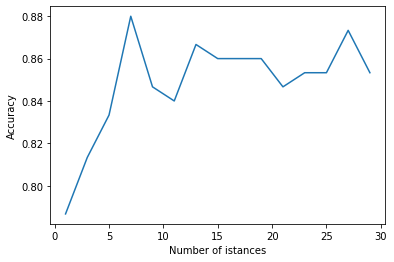

In [ ]:
x = list(range(1, mcl + 1, 2))
y = [r['accuracy'] for r in reports]
plt.plot(x,y)

plt.xlabel('Number of istances')
plt.ylabel('Accuracy')

plt.show()

This part of code is done to make a further analysis. There are better anchors ? There are bad anchors ? <br>
How much this influence the accuracy ? <br>
Why an anchors is bad and why may be good?


In order to reply this questions, the following approach is implemented.
For each user id, and for each anchor in the train set, the anchor is used to calculate the accuracy with all the train set. So the pairs created are (anchor, img_i) for each i in test set. The accuracy is calculated for each anchor.

In [26]:
threshold = 0.77

In [27]:
path_train = dataset_dir / "Train"
path_test = dataset_dir / "Test"
content = os.listdir(path_train)

n = len(content) // 2
n_train = int(n * 0.8)

anchors_acc = {}
for id in tqdm(range(n_train, n+1)):
  anchors_acc[id] = [[], []]
  folder_g_train = path_train / (str(id) + "_genuine")
  folder_g_content_train = os.listdir(path_train / folder_g_train)

  folder_g_test = path_test / (str(id) + "_genuine")
  folder_f_test = path_test / (str(id) + "_forged")
  folder_g_content_test = os.listdir(path_test / folder_g_test)
  folder_f_content_test = os.listdir(path_test / folder_f_test)

  for anchor in folder_g_content_train:
    count = 0
    path_anchor = folder_g_train / anchor
    anchor_obj = preprocess((folder_g_train / anchor).as_posix())

    for img in folder_g_content_test:
      img_obj = preprocess((folder_g_test / img).as_posix())
      if siamese.predict([np.array([anchor_obj]), np.array([img_obj])])[0] >= threshold: 
        count += 1
    for img in folder_f_content_test:
      img_obj = preprocess((folder_f_test / img).as_posix())
      if siamese.predict([np.array([anchor_obj]), np.array([img_obj])])[0] < threshold: 
        count += 1
    anchor_accuracy = count / (len(folder_g_content_test) + len(folder_f_content_test))
    anchors_acc[id][0].append(path_anchor)
    anchors_acc[id][1].append(anchor_accuracy)

100%|██████████| 23/23 [15:38<00:00, 40.80s/it]


A simple print suggest that there are anchors with 100% accuracy on test set, and anchors with 0.5 accuracy on test set. But why an anchor is better than another ?

In [ ]:
for id in range(n_train, n+1):
  print("[User "+str(id)+"]", "MAX", max(anchors_acc[id][1]), "MIN", min(anchors_acc[id][1]), "MEAN", np.mean(anchors_acc[id][1]))

[User 87] MAX 0.7142857142857143 MIN 0.5714285714285714 MEAN 0.6404761904761905
[User 88] MAX 1.0 MIN 1.0 MEAN 1.0
[User 89] MAX 0.75 MIN 0.5 MEAN 0.55
[User 90] MAX 1.0 MIN 0.5 MEAN 0.8833333333333333
[User 91] MAX 1.0 MIN 0.7 MEAN 0.8550000000000001
[User 92] MAX 1.0 MIN 0.5 MEAN 0.9291666666666667
[User 93] MAX 1.0 MIN 0.75 MEAN 0.8833333333333333
[User 94] MAX 1.0 MIN 0.5 MEAN 0.5666666666666667
[User 95] MAX 1.0 MIN 0.5 MEAN 0.8520833333333333
[User 96] MAX 1.0 MIN 0.5 MEAN 0.7583333333333333
[User 97] MAX 1.0 MIN 0.5 MEAN 0.9645833333333333
[User 98] MAX 1.0 MIN 0.6 MEAN 0.8666666666666668
[User 99] MAX 0.9 MIN 0.4 MEAN 0.6716666666666667
[User 100] MAX 1.0 MIN 0.5714285714285714 MEAN 0.9761904761904762
[User 101] MAX 1.0 MIN 0.7142857142857143 MEAN 0.876190476190476
[User 102] MAX 1.0 MIN 0.5 MEAN 0.9395833333333333
[User 103] MAX 0.875 MIN 0.5 MEAN 0.7104166666666667
[User 104] MAX 1.0 MIN 0.125 MEAN 0.5708333333333333
[User 105] MAX 1.0 MIN 0.625 MEAN 0.85625
[User 106] MAX 1.

In [ ]:
def visualize(best_anchor, best_acc, wrost_anchor, wrost_acc):
  plt.rcParams['figure.figsize'] = [15, 15]
  _ , axarr = plt.subplots(1,2)
  axarr[0].imshow(cv2.cvtColor(cv2.imread(best_anchor), cv2.COLOR_BGR2RGB))
  axarr[1].imshow(cv2.cvtColor(cv2.imread(wrost_anchor), cv2.COLOR_BGR2RGB))
  axarr[0].text(5, 5, "Accuracy " + str(best_acc), bbox={'facecolor': 'white', 'pad': 10})
  axarr[1].text(5, 5, "Accuracy " + str(wrost_acc), bbox={'facecolor': 'white', 'pad': 10})

In this part of code, are printed for each user id, one of the best anchor, and one of the worst anchor. To visually see what makes the difference.<br>

The anchors are visually similar, what we think that makes the different is the type of signature. This is explained better later.

One of the best anchors                     One of the wrost anchors


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


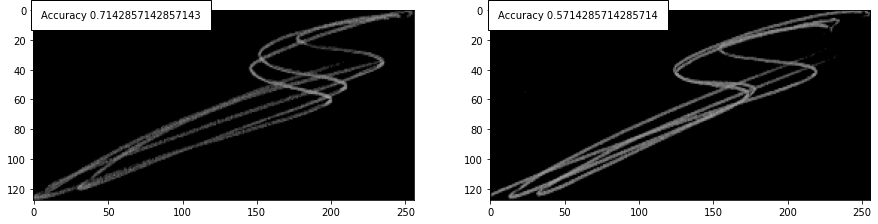

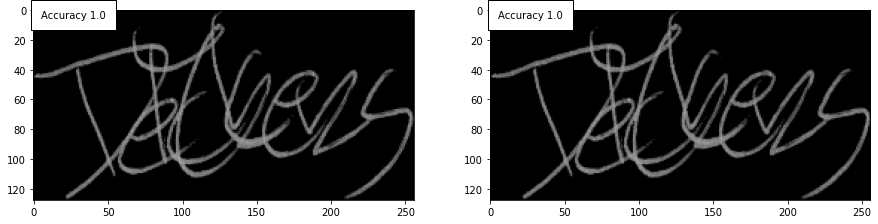

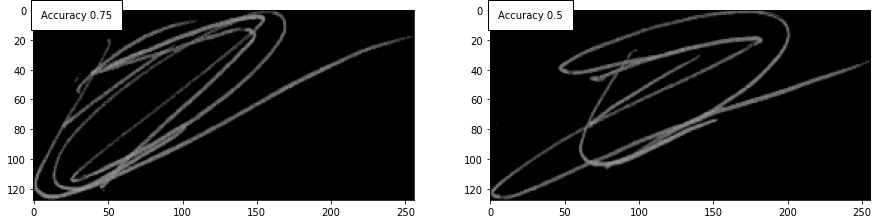

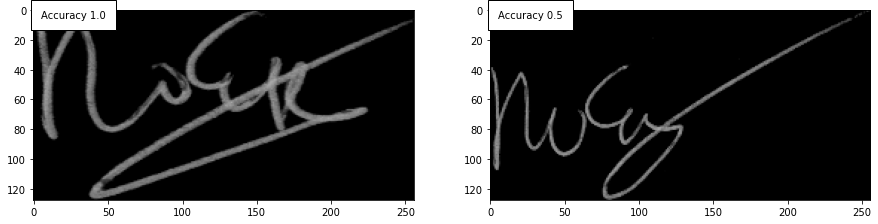

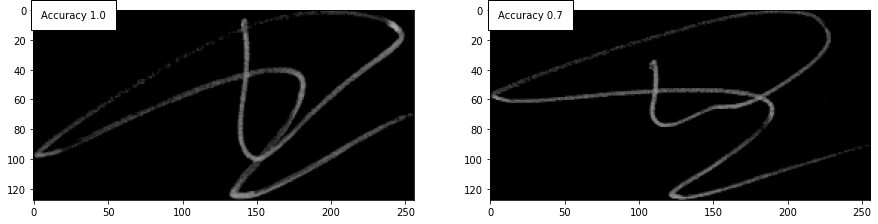

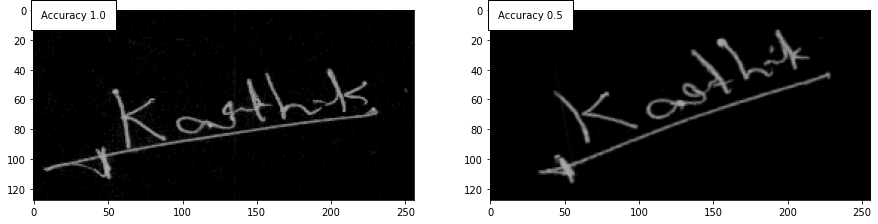

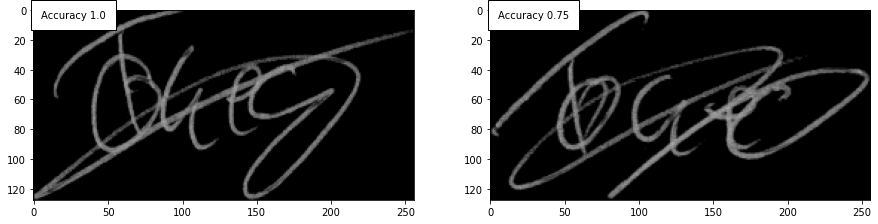

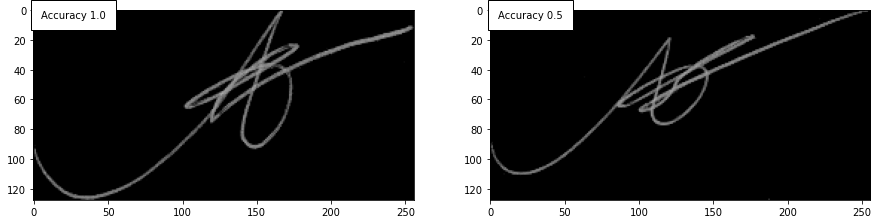

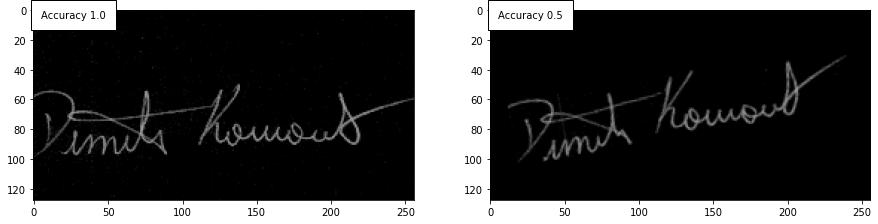

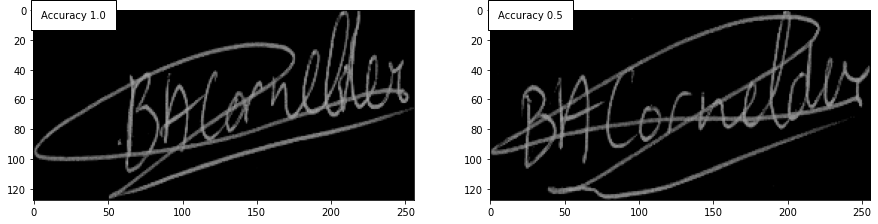

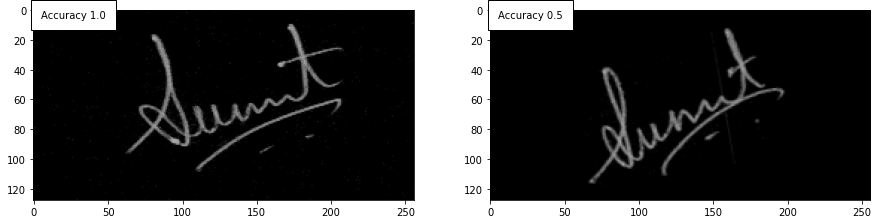

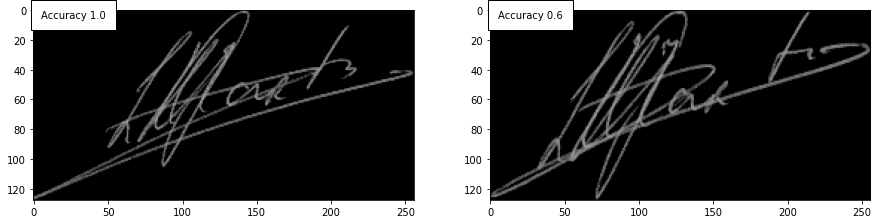

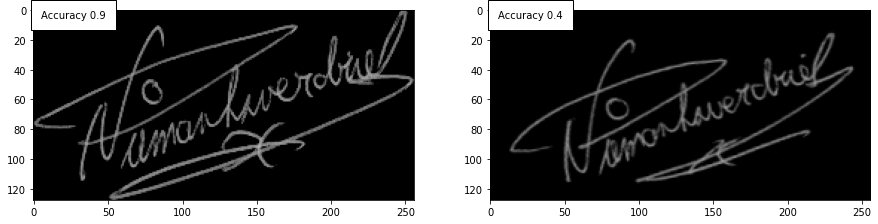

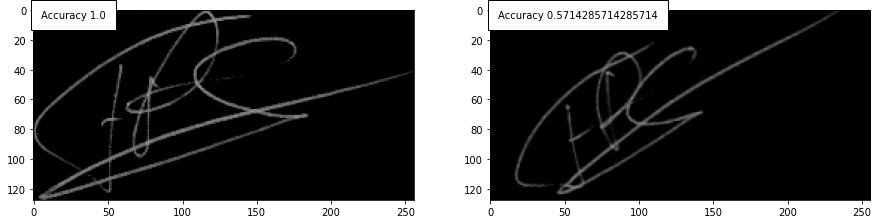

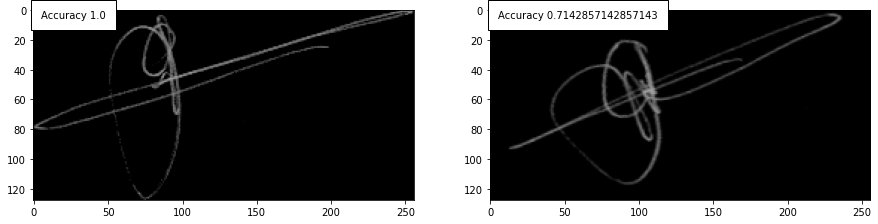

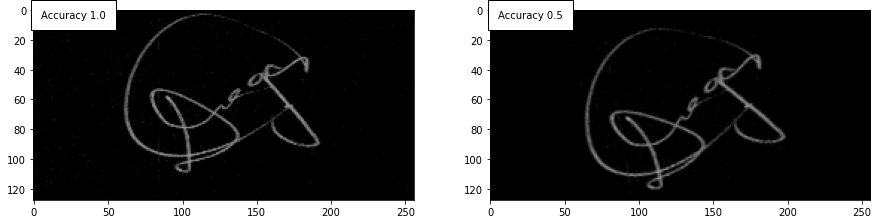

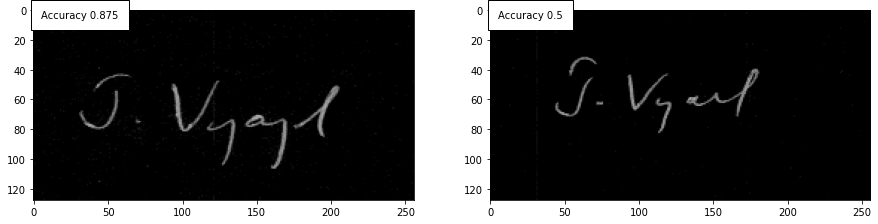

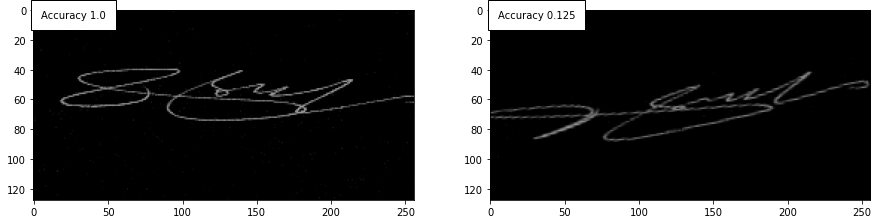

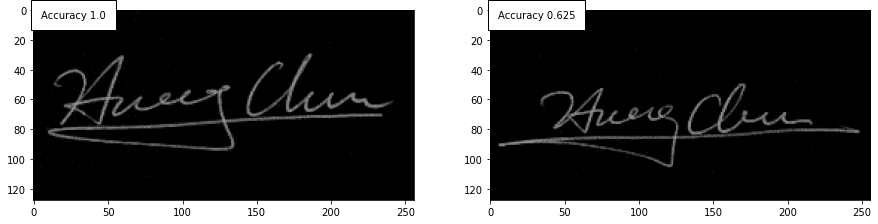

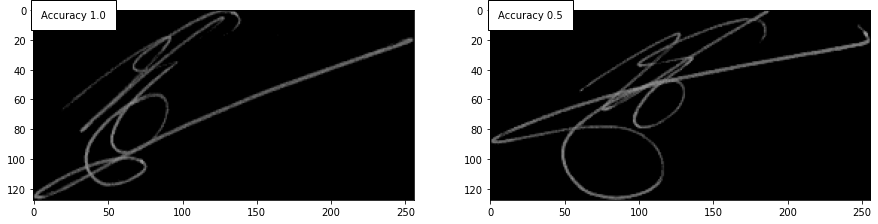

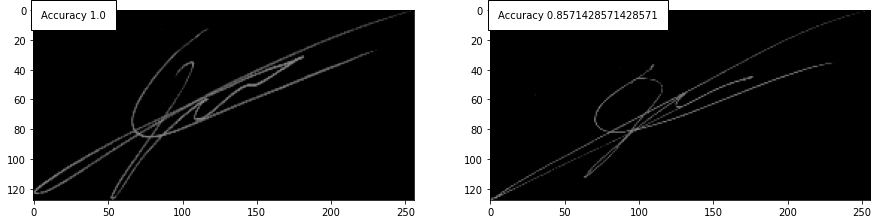

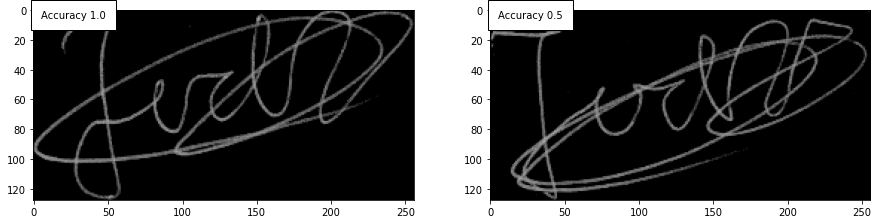

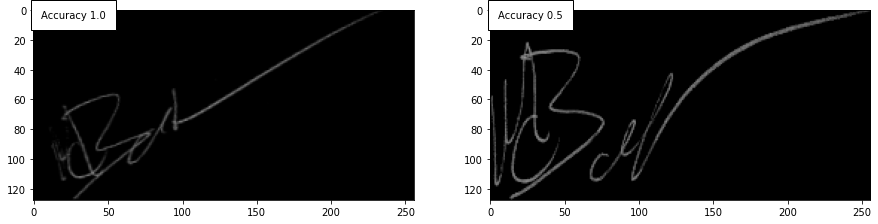

In [ ]:
print("One of the best anchors                     One of the wrost anchors")
for id in range(n_train, n+1):
  index_max = anchors_acc[id][1].index(max(anchors_acc[id][1]))
  index_min = anchors_acc[id][1].index(min(anchors_acc[id][1]))
  #print("Accuracy", anchors_acc[id][1][index_max], "                   Accuracy", anchors_acc[id][1][index_min])
  visualize(anchors_acc[id][0][index_max].as_posix(), anchors_acc[id][1][index_max],
            anchors_acc[id][0][index_min].as_posix(), anchors_acc[id][1][index_min])

In [ ]:
x = np.array(list(range(n_train, n+1)))
y_max = [max(anchors_acc[id][1]) for id in range(n_train, n+1)]
y_min = [min(anchors_acc[id][1]) for id in range(n_train, n+1)]
y_mean = [np.mean(anchors_acc[id][1]) for id in range(n_train, n+1)]

The min anchors accuracy, the max anchors accuracy and the mean anchors are plotted for each user id. 
As can be see in the plot, the majority of the user have both good anchors and bad anchors. 

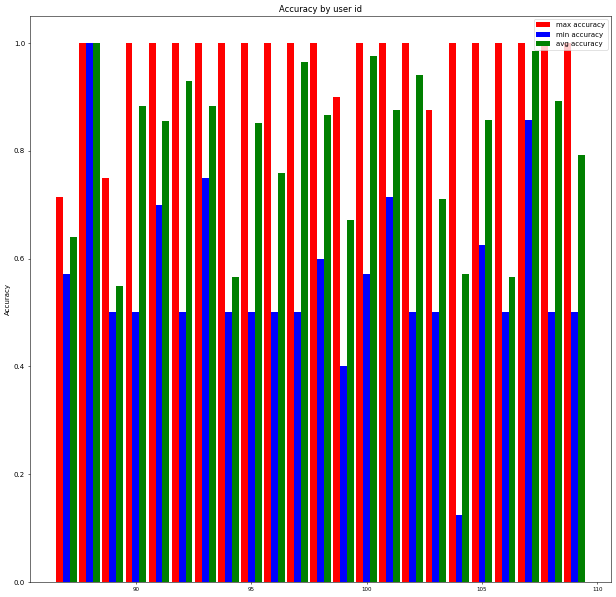

<Figure size 1080x1080 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
ax.bar(x-0.3, y_max, label='max accuracy',width = 0.3, color = 'red')
ax.bar(x, y_min, label='min accuracy', width = 0.3, color = 'blue')
ax.bar(x+0.3, y_mean, label='avg accuracy', width = 0.3, color = 'green')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by user id')
ax.legend()
fig.set_dpi(50)
plt.xticks(fontsize=8)
plt.figure()
plt.show()

Let's see how is the behaviour of a bad anchor for the user 97. <br>
User 97 has a MAX 1.0, MIN 0.5 and AVG 0.97 for anchors accuracies. <br>
The mean value of 0.97 suggests that the user has a very consistent signature, even if exists a low accuracy signature.
The threshold for binarize the prediction is fixed ad 0.77

For the worst anchor signature the output of the siamese model is displayed below

In [ ]:
anchor = (path_train/ "97_genuine" / "1.png").as_posix()
anchor_bad = (path_train/ "97_genuine" / "8_augmented_1.png").as_posix()

for img in os.listdir(path_test / "97_genuine"):
  img_path = (path_test/ "97_genuine" / img).as_posix()
  print("Predicted", siamese.predict([np.array([preprocess(anchor_bad)]), np.array([preprocess(img_path)])])[0][0],"Expected", 1)

for img in os.listdir(path_test / "97_forged"):
  img_path = (path_test/ "97_forged" / img).as_posix()
  print("Predicted", siamese.predict([np.array([preprocess(anchor_bad)]), np.array([preprocess(img_path)])])[0][0],"Expected", 0)

Predicted 0.6313748 Expected 1
Predicted 0.8725784 Expected 1
Predicted 0.7500011 Expected 1
Predicted 0.64807665 Expected 1
Predicted 0.82544 Expected 0
Predicted 0.38714337 Expected 0
Predicted 0.3735037 Expected 0
Predicted 0.3896027 Expected 0


This output suggest that the prediction is fault mainly for the positives, this means that the anchor is not sufficiently rappresentative of the signature of the user 97.

## Prove con firme nostre

In [42]:
def preprocess(img_path):
  img = cv2.imread(img_path, 1) # Only 1 channel
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Greyscale
  img[ img > 230 ] = 255
  img = cv2.bitwise_not(img) # Invert
  img = cv2.resize(img, (256, 128), interpolation = cv2.INTER_LINEAR) # is (128, 256) not (256, 128)
  
  img = np.array(img).astype("float32") / 255
  img = np.expand_dims(img, -1)
  return img

In [43]:
def visualize(best_anchor, best_acc, wrost_anchor, wrost_acc):
  plt.rcParams['figure.figsize'] = [15, 15]
  _ , axarr = plt.subplots(1,2)
  axarr[0].imshow(cv2.cvtColor(cv2.imread(best_anchor), cv2.COLOR_BGR2RGB))
  axarr[1].imshow(cv2.cvtColor(cv2.imread(wrost_anchor), cv2.COLOR_BGR2RGB))

##Poveromo Marco 

In [65]:
print("Predicted", siamese.predict([np.array([preprocess("/content/2.jpeg")]), np.array([preprocess("/content/4.jpeg")])])[0][0],"Expected", 1)

Predicted 0.73973215 Expected 1


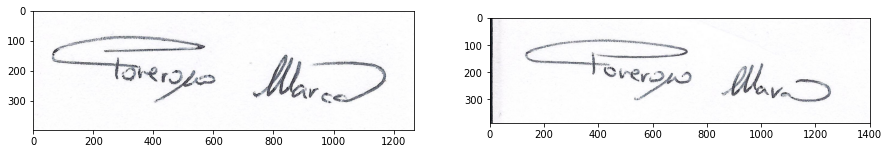

In [66]:
visualize("/content/2.jpeg", 1,"/content/4.jpeg",1)

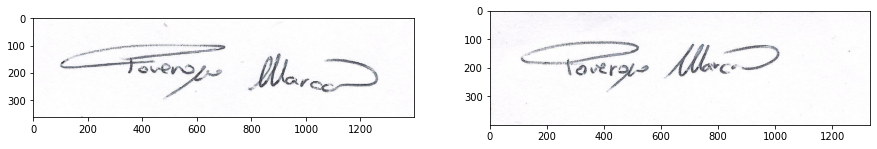

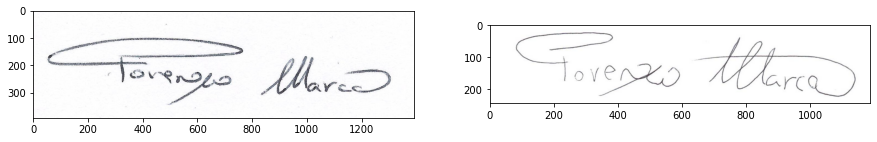

In [ ]:
visualize("/content/Poveromo_genuine/5.jpeg", 1,"/content/Poveromo_genuine/6.jpeg",1)
visualize("/content/Poveromo_genuine/1.jpeg", 1,"/content/Poveromo_forged/1.jpg",1)

In [ ]:
print("Predicted", siamese.predict([np.array([preprocess("/content/Poveromo_genuine/1.jpeg")]), np.array([preprocess("/content/Poveromo_genuine/8.jpeg")])])[0][0],"Expected", 1)
print("Predicted", siamese.predict([np.array([preprocess("/content/Poveromo_genuine/1.jpeg")]), np.array([preprocess("/content/Poveromo_forged/1.jpg")])])[0][0],"Expected", 0)

Predicted 0.35841504 Expected 1
Predicted 0.19748254 Expected 0


## Gabriele Di Lieto

In [ ]:
print("Predicted", siamese.predict([np.array([preprocess("/content/DiLieto_genuine/1.jpg")]), np.array([preprocess("/content/DiLieto_forged/1.jpeg")])])[0][0],"Expected", 0)
print("Predicted", siamese.predict([np.array([preprocess("/content/DiLieto_genuine/8.jpg")]), np.array([preprocess("/content/DiLieto_genuine/9.jpg")])])[0][0],"Expected", 1)

Predicted 0.01670848 Expected 0
Predicted 0.8332546 Expected 1


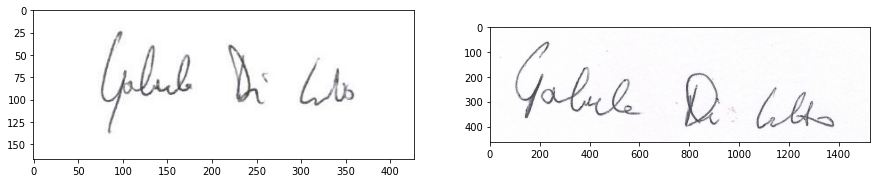

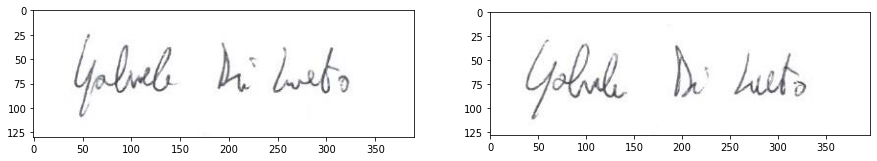

In [ ]:
visualize("/content/DiLieto_genuine/1.jpg", 1,"/content/DiLieto_forged/1.jpeg",1)
visualize("/content/DiLieto_genuine/8.jpg", 1,"/content/DiLieto_genuine/9.jpg",1)